In [35]:
# File Processing Imports
import os
CWD = os.getcwd()
print(CWD)
import shutil
import PIL
from PIL import Image

# ML-related imports
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Task-related Imports
import derm_ita

/mnt/e/APResearch/working


# Dataset Curation

## Step 1: Download the ISIC Challenge 2017 Dataset
*This step is not coded. Use Ctrl+C and Ctrl+V*\
https://challenge.isic-archive.com/landing/2017/43/

### Data Characteristics
1. 3 images splits: train, test, and validation\
2. superpixel images (appearing with red streaks on black backgrounds)\
3. 3 image classifications: melanoma, seborrheic keratosis, or neither\


### Folder Labeling
1. Part1_GroundTruth: contain image masks, which are white (value=255) where the lesion is, and black (value=0) where the lesion isn't\
2. Part2_GroundTruth: contain dermoscopic features\
3. Part3_GroundTruth csv files: contain 3 columns (image id, melanoma, seborrhic keratosis).\

### Image sizes:
Height: 767\
Width: 1022\
Channels: 3 (RGB)\
OR\
Height: 1129\
Width: 1504\
Channels: 3

### Metadata
Age (approximate, multiples of 5)\
Sex (male or female)\

## Step 2: Keep the images we want.

### Two Methods: 
1. make_dataset function below (takes a long while)
2. manual copy paste.
Items to keep are marked with a (K)\
\
Original Folder Names:\
(K)ISIC-2017_Test_v2_Data\
(K)ISIC-2017_Training_Data\
(K)ISIC-2017_Validation_Data\
ISIC-2017_Test_v2_Part1_GroundTruth\
ISIC-2017_Training_Part1_GroundTruth\
ISIC-2017_Validation_Part1_GroundTruth\
ISIC-2017_Test_v2_Part2_GroundTruth\
ISIC-2017_Training_Part2_GroundTruth\
ISIC-2017_Validation_Part2_GroundTruth\
\
CSV files:\
(K)ISIC-2017_Test_v2_Part3_GroundTruth.csv\
(K)ISIC-2017_Training_Part3_GroundTruth.csv\
(K)ISIC-2017_Validation_Part3_GroundTruth.csv\
\
Within ISIC-2017_Test_v2_Data:\
(K)ISIC-2017_Test_v2_Data_metadata.csv\
\
Within ISIC-2017_Training_Data:\
(K)ISIC-2017_Training_Data_metadata.csv\
\
Within ISIC-2017_Validation_Data:\
(K)ISIC-2017_Validation_Data_metadata.csv\

1. train, test, and validation original images, NOT the superpixel ones
2. original image metadata
3. csv files for Part3_GroundTruth

In [23]:
def make_dataset(path): # path should be the path to the folder in whcih you downloaded the original ISIC 2017 dataset.
    #os.mkdir(f'{CWD}/dataset/')
    data_splits = ["Test_v2","Training","Validation"]
    for split in data_splits:
        #os.mkdir(f'{CWD}/dataset/{split}_images')
        shutil.copy(f'{path}/ISIC-2017_{split}_Part3_GroundTruth.csv', f'{CWD}/dataset/{split}_labels.csv')
        shutil.copy(f'{path}/ISIC-2017_{split}_Data/ISIC-2017_{split}_Data_metadata.csv', f'{CWD}/dataset/{split}_metadata.csv')
        ids = os.listdir(f'{path}/ISIC-2017_{split}_Data')
        for id in ids:
            if id.find('.jpg') != -1:
                shutil.copy(f'{path}/ISIC-2017_{split}_Data/{id}', f'{CWD}/dataset/{split}_images/{id}')

make_dataset('/mnt/e/APResearch/ISIC Challenge 2017 Dataset')

In [25]:
def remove_superpixel_imgs(path): #imgfolder is a valid path to the folder containing the images with superpixels and og images.
    imgids = os.listdir(path=path)
    for id in imgids:
        if id.find('superpixels') != -1:
            os.remove(path=path+"/"+id)
data_splits = ["Test_v2","Training","Validation"]
for split in data_splits:
    remove_superpixel_imgs(f'{CWD}/dataset/ISIC-2017_{split}_Data')

## Step 3: Prepare Images for Training

1. Resize images to 224x224x3 (use padding)
2. Organize the dataset into subfolders according to the given labels. One folder should be melanoma, another is sehorrheic_keratosis, another is neither.

In [27]:
# Establish data directory: current working directory > dataset
data_dir = CWD + "/dataset/classified_images/"
os.mkdir(data_dir)
data_splits = ["Test_v2","Training","Validation"]
classifications = ['melanoma', 
                   'seborrheic_keratosis',
                   'neither']
for classification in classifications:
    os.mkdir(data_dir+classification)

In [31]:
def analyze_split(split):
    """
    We will evaluate the properties of the dataset:
    Information to gather: number of images in each split of the ISIC dataset
    Number of images of each classification
    """
    labels = pd.read_csv(f'{CWD}/dataset/{split}_labels.csv',  
                         index_col = 'image_id') # Read in the labels as a dataframe
    ids = list(labels.index.values)
    print(f'there are {len(ids)} images in the {split} folder.')
    """
    We can think of each image as having a two-digit label: 
    > the first digit represents the melanoma column, and is 0 or 1
    > the second digit represents the seborrheic_keratosis column, and is 0 or 1
    Thus,
    10 -> melanoma
    01 -> seborrheic_keratosis
    00 -> neither
    """
    count_10, count_01, count_00 = 0, 0, 0
    
    for id in ids:
        id = str(id)
        melanoma = labels.loc[id,'melanoma']
        seborrheic_keratosis = labels.loc[id,'seborrheic_keratosis']
        id = id + ".jpg"
        if melanoma == 1:
            count_10+=1
            shutil.copy(f'{CWD}/dataset/ISIC-2017_{split}_Data/{id}', 
                        f'{data_dir}melanoma/{id}')
        elif seborrheic_keratosis == 1:
            count_01+=1
            shutil.copy(f'{CWD}/dataset/ISIC-2017_{split}_Data/{id}', 
                        f'{data_dir}seborrheic_keratosis/{id}')
        else:
            count_00+=1
            shutil.copy(f'{CWD}/dataset/ISIC-2017_{split}_Data/{id}', 
                        f'{data_dir}neither/{id}')
    
    print(f'There are {count_10} images in the {split} folder labeled as melanoma')
    print(f'There are {count_01} images in the {split} folder labeled as seborrheic_keratosis')
    print(f'There are {count_00} images in the {split} folder labeled as neither')

In [32]:
for split in data_splits:
    analyze_split(split)
    print(f'{classification} ANALYSIS COMPLETE. Images resized.\n')

for classification in classifications:
    print(f'There are {len(os.listdir(data_dir+classification))} images labeled as {classification}')

there are 600 images in the Test_v2 folder.
There are 117 images in the Test_v2 folder labeled as melanoma
There are 90 images in the Test_v2 folder labeled as seborrheic_keratosis
There are 393 images in the Test_v2 folder labeled as neither
neither ANALYSIS COMPLETE. Images resized.

there are 2000 images in the Training folder.
There are 374 images in the Training folder labeled as melanoma
There are 254 images in the Training folder labeled as seborrheic_keratosis
There are 1372 images in the Training folder labeled as neither
neither ANALYSIS COMPLETE. Images resized.

there are 150 images in the Validation folder.
There are 30 images in the Validation folder labeled as melanoma
There are 42 images in the Validation folder labeled as seborrheic_keratosis
There are 78 images in the Validation folder labeled as neither
neither ANALYSIS COMPLETE. Images resized.

There are 521 images labeled as melanoma
There are 386 images labeled as seborrheic_keratosis
There are 1843 images labele

In [33]:
def resize_imgs(classification): 
    img_folder = os.listdir(f'{data_dir}{classification}')

    for img in img_folder:
        imgfile = image.load_img(
            path = f'{data_dir}{classification}/{img}',
            color_mode = "rgb",
            target_size = None,
            interpolation="bilinear", #test with different ones, there is "nearest" "bilinear" and "bicubic" -> bicubic is computationally intensive, so I will go with bilinear
            keep_aspect_ratio = True 
            )
        imgfile = tf.image.resize_with_pad(
            imgfile,
            target_height = 224,
            target_width = 224,
            antialias=False
        )
        imgfile = utils.img_to_array(imgfile)
        image.save_img(path = f'{data_dir}{classification}/{img}', 
                       x=imgfile) # Replacing the old images

In [34]:
for classification in classifications:
    resize_imgs(classification)

2023-12-30 18:50:29.963644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-30 18:50:30.193726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-30 18:50:30.193770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-30 18:50:30.197086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-30 18:50:30.197121: I tensorflow/compile

In [37]:
# Set train and validation datasets
train_ds = trainset = keras.utils.image_dataset_from_directory(
    directory=f"{CWD}/dataset/classified_images",
    labels="inferred",
    batch_size=32, #this doesn't rlly matter as a param, but wtv!
    image_size=(224,224),
    seed = 123,
    validation_split=0.2,
    subset="training",
    )

val_ds = keras.utils.image_dataset_from_directory(
    directory=f"{CWD}/dataset/classified_images",
    labels="inferred",
    batch_size=32, #this doesn't rlly matter as a param, but wtv!
    image_size=(224,224),
    seed = 123,
    validation_split=0.2,
    subset="validation",
    )


Found 2750 files belonging to 3 classes.
Using 2200 files for training.
Found 2750 files belonging to 3 classes.
Using 550 files for validation.


In [38]:
class_names = train_ds.class_names
print(class_names)

['melanoma', 'neither', 'seborrheic_keratosis']


2023-12-30 18:57:04.708684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2200]
	 [[{{node Placeholder/_4}}]]
2023-12-30 18:57:04.708995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2200]
	 [[{{node Placeholder/_0}}]]


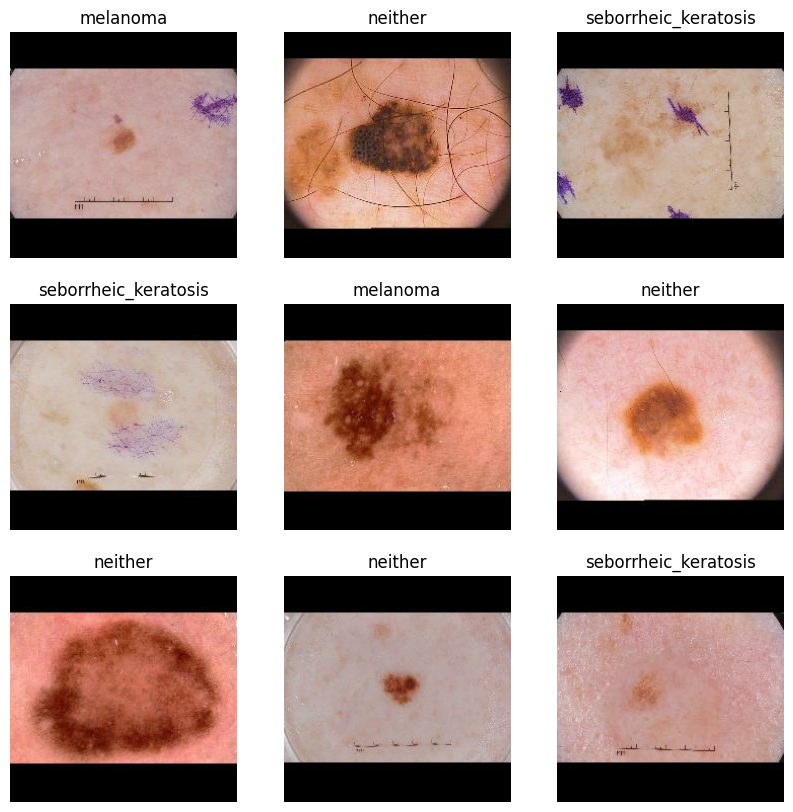

In [39]:
# Observing some images from our dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-12-30 18:57:13.912660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2200]
	 [[{{node Placeholder/_4}}]]
2023-12-30 18:57:13.913002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2200]
	 [[{{node Placeholder/_0}}]]


(32, 224, 224, 3)
(32,)


## Step 4: Train Model

In [41]:
# Improving efficiency 
# Source: https://www.tensorflow.org/tutorials/images/classification
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
# ResNet50V2
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
core = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights=None, # We will not use transfer learning here, since our classes are completely different from basic stuff.
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
x = core(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

In [43]:
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 tf.cast (TFOpLambda)        (None, None, None, 3)     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, None, None, 3)    0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, None, None, 3)    0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 1000)              25613800  
                                                                 
Total params: 25,613,800
Trainable params: 25,568,360
Non-tra

In [44]:
# Train model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-12-30 18:57:27.446689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2200]
	 [[{{node Placeholder/_4}}]]
2023-12-30 18:57:27.447024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2200]
	 [[{{node Placeholder/_4}}]]
/root/miniconda3/envs/apresearch/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits

69/69 [==============================] - ETA: 0s - loss: 1.0961 - accuracy: 0.6532

2023-12-30 18:58:19.672156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [550]
	 [[{{node Placeholder/_4}}]]
2023-12-30 18:58:19.672478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [550]
	 [[{{node Placeholder/_4}}]]


69/69 [==============================] - 56s 379ms/step - loss: 1.0961 - accuracy: 0.6532 - val_loss: 1.1989 - val_accuracy: 0.1564
Epoch 2/10
69/69 [==============================] - 21s 307ms/step - loss: 0.7836 - accuracy: 0.6791 - val_loss: 1.9351 - val_accuracy: 0.1564
Epoch 3/10
69/69 [==============================] - 21s 304ms/step - loss: 0.7521 - accuracy: 0.6964 - val_loss: 1.4980 - val_accuracy: 0.3273
Epoch 4/10
69/69 [==============================] - 21s 311ms/step - loss: 0.7558 - accuracy: 0.6941 - val_loss: 0.8943 - val_accuracy: 0.5927
Epoch 5/10
69/69 [==============================] - 21s 306ms/step - loss: 0.7198 - accuracy: 0.7077 - val_loss: 0.8048 - val_accuracy: 0.6236
Epoch 6/10
69/69 [==============================] - 21s 304ms/step - loss: 0.7139 - accuracy: 0.7000 - val_loss: 1.1192 - val_accuracy: 0.5218
Epoch 7/10
69/69 [==============================] - 21s 304ms/step - loss: 0.7131 - accuracy: 0.7123 - val_loss: 0.7750 - val_accuracy: 0.6855
Epoch 8/10

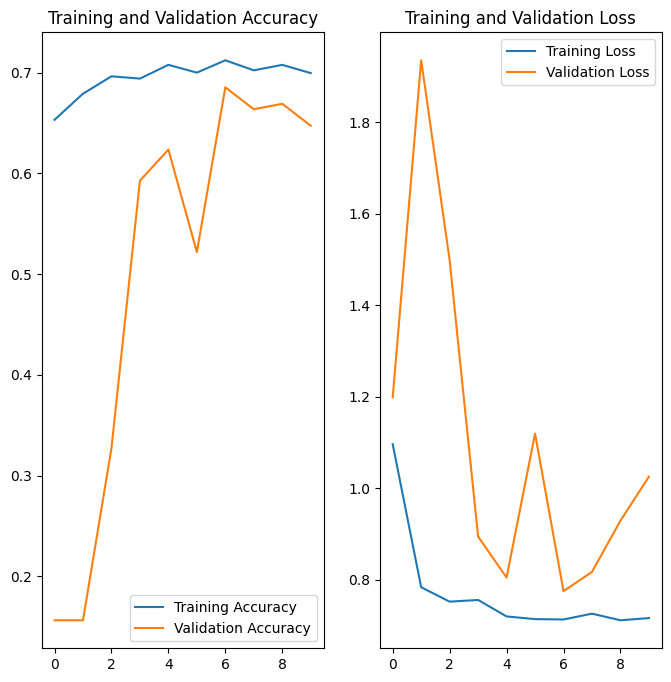

In [45]:
# Visualize Training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Step 5: Train model on modified dataset

### Artifacts
Because the original ISIC Challenge 2017 Datset was meant to test segmentation algorithms alongside regular melanoma detection algorithms, several images in the test/train/validation dataset contain visual artifacts.\
These artifacts take the form of large circles that might have been artificially added with computer software or are the result of dermatologists using stickers to cover up lesions they were not trying to capture in their dermascopy.\
I created a new folder called artifacted_images, which contains subfolders corresponding to the classifications (melanoma, neither, and seborrheic_keratosis). I then manually looked through every image in each classification and \
copy + pasted the artifacted ones into the corresponding folder in artifacted_images.\

### Compile new, artifact-free dataset
The code below slightly modifies the original dataset by removing the artifacted images. 

In [58]:
# Clear session to free up GPU memory
keras.backend.clear_session()

In [50]:
for classification in classifications:
    print(f'There are {len(os.listdir(f"{CWD}/dataset/classified_images_no_artifacts/{classification}"))} images labeled as {classification}')
    print(f'There are {len(os.listdir(f"{CWD}/dataset/artifacted_images/{classification}"))} labeled as {classification} that contain artifacts')

There are 520 images labeled as melanoma
There are 1 labeled as melanoma that contain artifacts
There are 375 images labeled as seborrheic_keratosis
There are 11 labeled as seborrheic_keratosis that contain artifacts
There are 1702 images labeled as neither
There are 141 labeled as neither that contain artifacts


In [55]:
# Set train and validation datasets
train_ds_no_artifacts = trainset = keras.utils.image_dataset_from_directory(
    directory=f"{CWD}/dataset/classified_images_no_artifacts",
    labels="inferred",
    batch_size=32, #this doesn't rlly matter as a param, but wtv!
    image_size=(224,224),
    seed = 123,
    validation_split=0.2,
    subset="training",
    )

val_ds_no_artifacts = keras.utils.image_dataset_from_directory(
    directory=f"{CWD}/dataset/classified_images_no_artifacts",
    labels="inferred",
    batch_size=32, #this doesn't rlly matter as a param, but wtv!
    image_size=(224,224),
    seed = 123,
    validation_split=0.2,
    subset="validation",
    )

class_names = train_ds_no_artifacts.class_names
print(class_names)

for image_batch, labels_batch in train_ds_no_artifacts:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 2597 files belonging to 3 classes.
Using 2078 files for training.
Found 2597 files belonging to 3 classes.
Using 519 files for validation.
['melanoma', 'neither', 'seborrheic_keratosis']


2023-12-30 19:37:38.496329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2078]
	 [[{{node Placeholder/_0}}]]
2023-12-30 19:37:38.496622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2078]
	 [[{{node Placeholder/_0}}]]


(32, 224, 224, 3)
(32,)


## Step 6: Retrain the model

In [54]:
# Recompile the Model


# Improving efficiency 
# Source: https://www.tensorflow.org/tutorials/images/classification
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# ResNet50V2
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
core = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights=None, # We will not use transfer learning here, since our classes are completely different from basic stuff.
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
x = core(x)
model = tf.keras.Model(inputs=[i], outputs=[x])
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 tf.cast (TFOpLambda)        (None, None, None, 3)     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, None, None, 3)    0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, None, None, 3)    0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 1000)              25613800  
                                                                 
Total params: 25,613,800
Trainable params: 25,568,360
Non-tra

In [56]:
# Train model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-12-30 19:37:42.572415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2078]
	 [[{{node Placeholder/_4}}]]
2023-12-30 19:37:42.572752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2078]
	 [[{{node Placeholder/_0}}]]
/root/miniconda3/envs/apresearch/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logit

65/65 [==============================] - ETA: 0s - loss: 1.1154 - accuracy: 0.6083

2023-12-30 19:38:28.094702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [519]
	 [[{{node Placeholder/_4}}]]
2023-12-30 19:38:28.095060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [519]
	 [[{{node Placeholder/_0}}]]


65/65 [==============================] - 49s 390ms/step - loss: 1.1154 - accuracy: 0.6083 - val_loss: 1.5457 - val_accuracy: 0.1908
Epoch 2/10
65/65 [==============================] - 20s 308ms/step - loss: 0.8172 - accuracy: 0.6497 - val_loss: 1.3223 - val_accuracy: 0.1946
Epoch 3/10
65/65 [==============================] - 20s 308ms/step - loss: 0.7943 - accuracy: 0.6728 - val_loss: 1.1211 - val_accuracy: 0.4239
Epoch 4/10
65/65 [==============================] - 20s 310ms/step - loss: 0.7776 - accuracy: 0.6704 - val_loss: 2.4081 - val_accuracy: 0.1638
Epoch 5/10
65/65 [==============================] - 20s 309ms/step - loss: 0.7850 - accuracy: 0.6732 - val_loss: 0.8975 - val_accuracy: 0.5973
Epoch 6/10
65/65 [==============================] - 20s 309ms/step - loss: 0.7736 - accuracy: 0.6761 - val_loss: 0.7992 - val_accuracy: 0.6243
Epoch 7/10
65/65 [==============================] - 20s 308ms/step - loss: 0.7576 - accuracy: 0.6708 - val_loss: 0.7865 - val_accuracy: 0.6185
Epoch 8/10

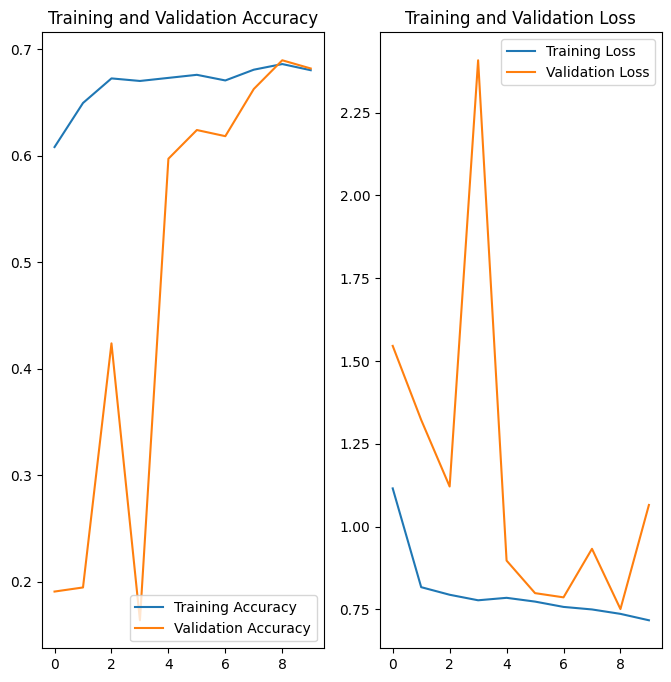

In [57]:
# Visualize Training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()